# Modeling Hodgkin Lymphoma and Associated Treatment Guidelines in OWL [Part II. Interacting With Ontology] - Python Extension

#### Hannah Grossman (HLG), Matt Schwede (MSchwede), Julie Kong (ejkong), Michal Zielinski (mzielinski)

#### Load packages

In [1]:
# !pip3 install owlready2
from owlready2 import *
import owlready2

In [2]:
root_dir = '/Users/hgrossman/stanford/bmi210'

### Load ontology and sync reasoner

In [3]:
onto2 = get_ontology(f"{root_dir}/HodgkinInstances.owl").load()

with onto2:
    sync_reasoner_pellet([onto2], infer_property_values=True)

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/httpclient-4.2.3.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/aterm-java-1.6.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/xercesImpl-2.10.0.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/jena-tdb-0.10.0.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/jena-iri-0.9.5.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/owlapi-distribution-3.4.3-bin.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/log4j-1.2.16.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/antlr-runtime-3.2.jar:/opt/anaconda3/lib/python3.8/site-packages

### Create a Patient Class to dynamically interact with our ontology

Based on the NCCN guidelines:
* we are limiting our `AboveDiaphragm` and `BelowDiaphragm nodes`, `'above'` and `'below'` respectively, to the following possible instances. 
* we are limiting creation of lymph nodes to Above and Below only, no general `LymphNodeRegion`
* any `localized`, `distant`, or `spleen` `ExtraNodalRegions` need to have the string names `'localized'`, `'distant'`, or `'spleen'`, respectively
* `BSymptoms` are limited to that of `'fever'`, `'night sweats'`, and `'weight loss'`
* classic histology includes: `"classic Hodgkin lymphoma"` , `"lymphocyte depleted"` , `"lymphocyte rich"` , `"mixed cellularity"`, `"nodular sclerosis"`
* nodular histology includes: `"nodular lymphocyte predominant"`

In [4]:
above = ['LAxilla', 'LCervicalSCL', 'LHilum', 'LICLSubpectoral', 'Mediastinum', 'RAxilla', 'RCervicalSCL', 'RHilum', 'RICLSubpectoral']
below = ['Liliac', 'LInguinalFemoral', 'Mesenteric', 'RInguinalFemoral', 'RIliac']
localized = ['localized']
distant = ['distant']
spleen = ["spleen"]
bsymptoms = ['fever', 'night sweats', 'weight loss']

classic_histology = ["classic Hodgkin lymphoma" , "lymphocyte depleted" , "lymphocyte rich" , "mixed cellularity" , "nodular sclerosis"]
nodular_histology = ["nodular lymphocyte predominant"]

In [5]:
class Patient:
    def __init__(self, name: str, age: int, gender: str, ontology):
        if gender not in ["Male", "Female"]:
            raise Exception(f"gender must be Male or Female, not {gender}")
        
        self.name = name
        self.above_diaphragm = []
        self.below_diaphragm = []
        self.symptoms = []
        self.extra_nodal_regions = []
        self.presence_of_bulky_mass = False
        self.presence_of_mediastinal_mass = False
        self.presence_of_bsymptoms = False
        self.histology = None
        self.stage = None
        self.ontology = ontology

    def set_nodal_regions(self, nodes: list) -> None:
        for node in nodes:
            if node in above:
                self.set_above_diaphragm(node)
            elif node in below:
                self.set_below_diaphragm(node) 
    def set_above_diaphragm(self, node: str) -> None:
        onto_node = self.ontology.AboveDiaphragm(node)
        self.above_diaphragm.append(onto_node)     
    def set_below_diaphragm(self, node: str) -> None:
        onto_node = self.ontology.BelowDiaphragm(node)
        self.below_diaphragm.append(onto_node)                
    
    def set_symptoms(self, symptoms: list) -> None:
        for symptom in symptoms:
            if symptom in bsymptoms:
                self.presence_of_bsymptoms = True
                self.symptoms.append(self.ontology.BSymptoms(symptom))
            AllDifferent(self.symptoms)

    def set_extranodal_regions(self, nodes: list) -> None:
        for node in nodes:
            if node in localized:
                self.set_localized(node)
            elif node in distant:
                self.set_distant(node)
            elif node in spleen:
                self.set_spleen(node)
            AllDifferent(self.extra_nodal_regions)
    def set_localized(self, node: str) -> None:
        onto_node = self.ontology.Localized(node)
        self.extra_nodal_regions.append(onto_node)    
    def set_distant(self, node: str) -> None:
        onto_node = self.ontology.Distant(node)
        self.extra_nodal_regions.append(onto_node)        
    def set_spleen(self, node: str) -> None:
        onto_node = self.ontology.Spleen(node)
        self.extra_nodal_regions.append(onto_node)        
    
    def set_mediastinal_mass(self, mass_present: bool) -> None:
        self.presence_of_mediastinal_mass = mass_present
    
    def set_bulky_mass(self, mass_bulky: bool) -> None:
        # mass size greater than 10cm
        self.presence_of_bulky_mass = mass_bulky
        
    def set_all(self, lymph: list, extra: list, symptoms: list, bulky: bool, mediastinal: bool, histology: str):
        self.set_nodal_regions(lymph)
        self.set_extranodal_regions(extra)
        self.set_symptoms(symptoms)
        self.set_mediastinal_mass(mediastinal)
        self.set_bulky_mass(bulky)
        self.histology = histology
        
        self.ontology.Stage(self.name,
                            has_above_diaphragm=self.above_diaphragm,
                            has_below_diaphragm=self.below_diaphragm,
                            has_extra_nodal_region=self.extra_nodal_regions,
                            has_symptoms=self.symptoms)
        
    def set_stage(self, stage: str):
        self.stage = stage

#### Get stage from the inferred classes

In [6]:
def get_stage(individual, ontology):
    for parent in ontology.get_parents_of(individual):
        parent_str = str(parent).split('.')[-1]
        if parent_str in ['IV', 'III', 'IIA', 'IIB', 'IA', 'IB']:
            return parent_str
    return 'Stage not found'

#### Create a Hodgkin Lymphoma class to determine Hodgkin Lymphoma classification based on patient histology & stage

In [7]:
def HodgkinLymphoma(patient: any):
    if patient.stage == 'IA' or patient.stage == 'IIA' or patient.stage == 'IB' or patient.stage == 'IIB':
        if patient.histology in classic_histology:
            if patient.presence_of_mediastinal_mass or patient.presence_of_bulky_mass or patient.presence_of_bsymptoms:
                return 'Early Classic: Unfavorable'
            else:
                return 'Early Classic: Favorable'
        elif patient.histology in nodular_histology:
            return 'Early Nodular Lymphocyte Predominant'
    elif patient.stage == 'III' or patient.stage == 'IV':
        if patient.histology in classic_histology:
            return 'Late Classic'
        elif patient.histology in nodular_histology:
            return 'Late Nodular Lymphocyte Predominant'

### Create Patients

##### Create a patient Caroline with Stage IIB Early Classic: Unfavorable

In [8]:
caroline = Patient("Caroline", 22, "Female", ontology=onto2)

symptoms = ['fever', 'night sweats']
lymph_nodes = ['RCervicalSCL', 'RAxilla']

caroline.set_all(lymph_nodes, [], symptoms, None, None, "classic Hodgkin lymphoma")

##### Create a patient Robert with Stage IB Early Nodular Lymphocyte Predominate

In [9]:
robert = Patient("Robert", 45, 'Male', ontology=onto2)

distant_nodes = ["localized"]
symptoms = ["weight loss"]

robert.set_all([], distant_nodes, symptoms, None, None, "nodular lymphocyte predominant")

##### Create a patient Betsy with Stage III Late Classic

In [10]:
betsy = Patient("Betsy", 29, "Female", ontology=onto2)

lymph_nodes = ['LAxilla', 'LCervicalSCL', 'Mesenteric']
distant_nodes = ["spleen"]

betsy.set_all(lymph_nodes, distant_nodes, [], None, None, "nodular sclerosis")

Close the world and save the ontolgy

In [11]:
owlready2.close_world(onto2.Caroline)
owlready2.close_world(onto2.Robert)
owlready2.close_world(onto2.Betsy)

AllDifferent(list(onto2.individuals()))

AllDisjoint([HodgkinInstances.celiac, HodgkinInstances.celiac2, HodgkinInstances.distant, HodgkinInstances.distant2, HodgkinInstances.fever, HodgkinInstances.kidney, HodgkinInstances.laxilla, HodgkinInstances.laxilla2, HodgkinInstances.liver, HodgkinInstances.localized, HodgkinInstances.thyroid, HodgkinInstances.1a, HodgkinInstances.1b, HodgkinInstances.2a, HodgkinInstances.2a_, HodgkinInstances.2b, HodgkinInstances.2b_, HodgkinInstances.3, HodgkinInstances.4, HodgkinInstances.4_, HodgkinInstances.RCervicalSCL, HodgkinInstances.RAxilla, HodgkinInstances.night sweats, HodgkinInstances.Caroline, HodgkinInstances.weight loss, HodgkinInstances.Robert, HodgkinInstances.LAxilla, HodgkinInstances.LCervicalSCL, HodgkinInstances.Mesenteric, HodgkinInstances.spleen, HodgkinInstances.Betsy])

In [12]:
def save_ontology(ontology):
    ontology.save(f"/{root_dir}/HodgkinInstances.owl")

In [13]:
save_ontology(onto2)

### Close the world for the Patient instances and sync the ontology

In [14]:
with onto2:
    sync_reasoner_pellet([onto2], infer_property_values=True)

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/httpclient-4.2.3.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/aterm-java-1.6.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/xercesImpl-2.10.0.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/jena-tdb-0.10.0.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/jena-iri-0.9.5.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/owlapi-distribution-3.4.3-bin.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/log4j-1.2.16.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/opt/anaconda3/lib/python3.8/site-packages/owlready2/pellet/antlr-runtime-3.2.jar:/opt/anaconda3/lib/python3.8/site-packages

In [15]:
# Caroline was properly inferred as IIB
caroline.set_stage(get_stage(onto2.Caroline, onto2))
print(f'Stage(caroline) = {caroline.stage}')

# Robert was properly inferred as IB
robert.set_stage(get_stage(onto2.Robert, onto2))
print(f'Stage(robert) = {robert.stage}')

# Betsy was properly inferred as III
betsy.set_stage(get_stage(onto2.Betsy, onto2))
print(f'Stage(betsy) = {betsy.stage}')

Stage(caroline) = IIB
Stage(robert) = IB
Stage(betsy) = III


#### We have correctly inferred the appropriate stage for all three of our patients!

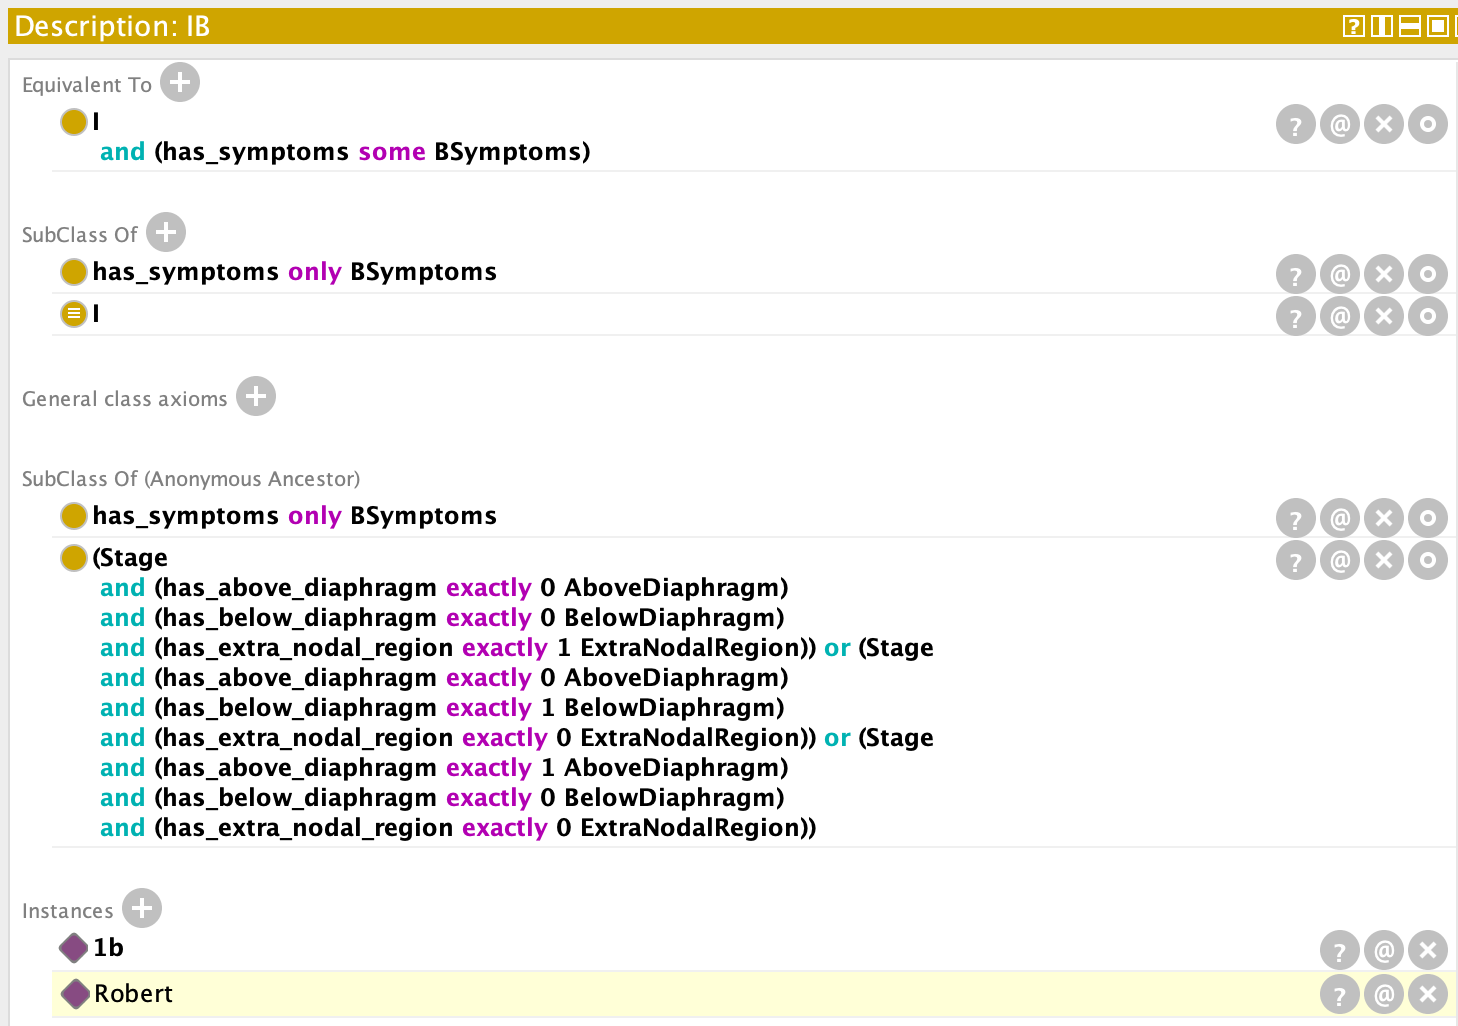

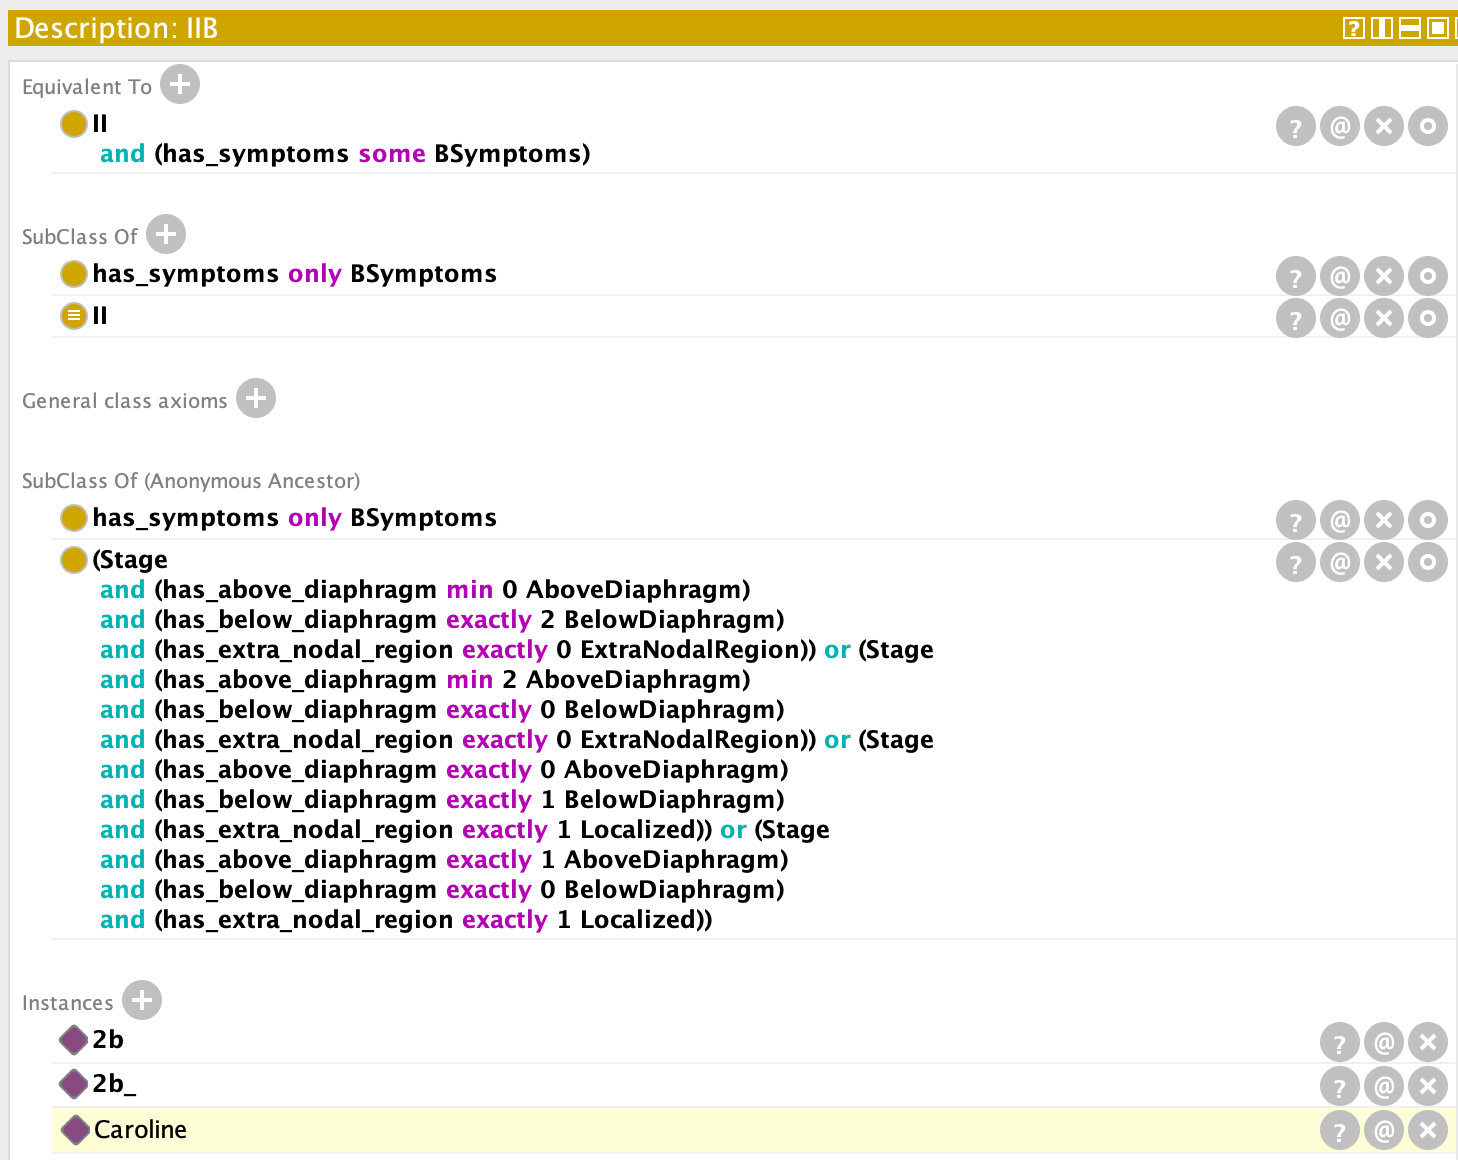

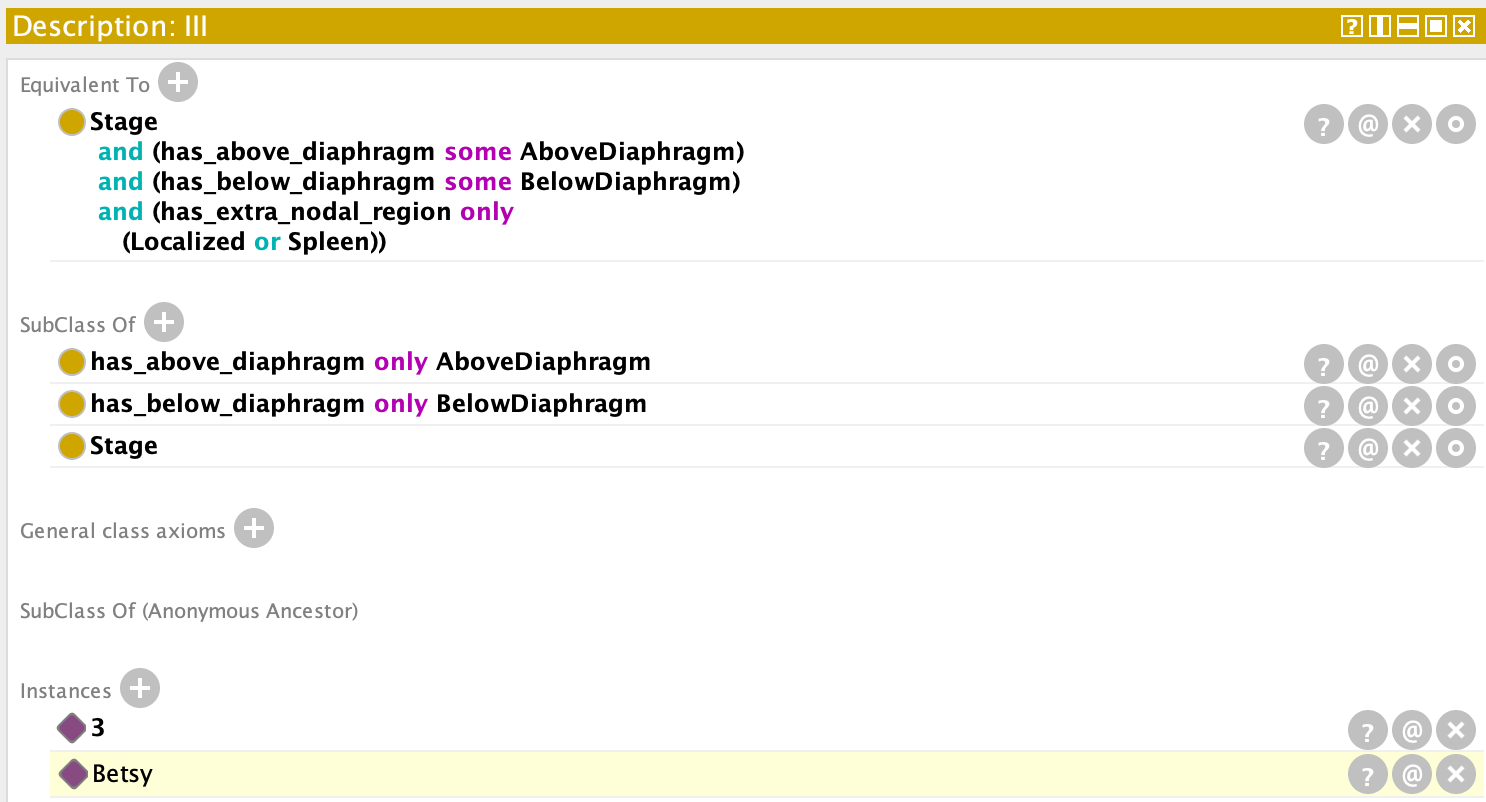

### Get treatment from inferred stage for each Patient

Based on the NCCN guidelines, the treatments for each patient should be as the following:
* Early Classic, Favorable: `ABVD`
* Early Classic, Unfavorable: `ABVD + more intensive therapy`
* Late Classic: `ABVD + AVD, BEACOPP, or BV-AV`
* Early Nodular Lymphocyte Predominant: `Observation or radiation or (radiation + chemotherapy + rituximab)`
* Late Nodular Lymphocyte Predominant: `Observation or rituximab or (chemotherapy + rituximab +/- radiation) or palliative radiation`

In [45]:
def get_treatment(lymphoma_type):
    mapping = {
        'Early Classic: Favorable': "ABVD",
        'Early Classic: Unfavorable': "ABVD + more intensive therapy",
        'Late Classic': "ABVD + AVD, BEACOPP, or BV-AVD",
        'Early Nodular Lymphocyte Predominant': 'Observation or radiation or (radiation + chemotherapy + rituximab)', 
        'Late Nodular Lymphocyte Predominant': 'Observation or rituximab or (chemotherapy + rituximab +/- radiation) or palliative radiation',
    }
    return mapping[lymphoma_type]

### Summary

In [46]:
def get_patient_info(individual):
    print(f'{individual.name} has lymph nodes above diaphragm: {individual.above_diaphragm},\
    lymph nodes below diaphragm: {individual.below_diaphragm},\
    symptoms: {individual.symptoms},\
    extra nodal regions: {individual.extra_nodal_regions},\
    presence of bulky mass: {individual.presence_of_bulky_mass},\
    presence of mediastinal mass: {individual.presence_of_mediastinal_mass},\
    presence of mediastinal mass: {individual.presence_of_mediastinal_mass},\
    histology: {individual.histology},\
    stage: {individual.stage}. The patient should receive the following treatment: {get_treatment(HodgkinLymphoma(individual))}.')

In [47]:
get_patient_info(caroline)

Caroline has lymph nodes above diaphragm: [HodgkinInstances.RCervicalSCL, HodgkinInstances.RAxilla],    lymph nodes below diaphragm: [],    symptoms: [HodgkinInstances.fever, HodgkinInstances.night sweats],    extra nodal regions: [],    presence of bulky mass: None,    presence of mediastinal mass: None,    presence of mediastinal mass: None,    histology: classic Hodgkin lymphoma,    stage: IIB. The patient should receive the following treatment: ABVD + more intensive therapy.


In [48]:
get_patient_info(robert)

Robert has lymph nodes above diaphragm: [],    lymph nodes below diaphragm: [],    symptoms: [HodgkinInstances.weight loss],    extra nodal regions: [HodgkinInstances.localized],    presence of bulky mass: None,    presence of mediastinal mass: None,    presence of mediastinal mass: None,    histology: nodular lymphocyte predominant,    stage: IB. The patient should receive the following treatment: Observation or radiation or (radiation + chemotherapy + rituximab).


In [49]:
get_patient_info(betsy)

Betsy has lymph nodes above diaphragm: [HodgkinInstances.LAxilla, HodgkinInstances.LCervicalSCL],    lymph nodes below diaphragm: [HodgkinInstances.Mesenteric],    symptoms: [],    extra nodal regions: [HodgkinInstances.spleen],    presence of bulky mass: None,    presence of mediastinal mass: None,    presence of mediastinal mass: None,    histology: nodular sclerosis,    stage: III. The patient should receive the following treatment: ABVD + AVD, BEACOPP, or BV-AVD.
